In [39]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [40]:
torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


# Training a neural network with PyTorch

This notebook trains a neural network to approximate the $\sin$ function, but using `PyTorch` instead of `NumPy`.

First thing to note: `PyTorch` can almost be used as a `NumPy` replacement, with tensors instead of arrays. Because `PyTorch` allows computations on GPU, we can choose on which device to store the tensors.

In [41]:
n = 1024
x = np.random.uniform(-np.pi, np.pi, size=(n, 1)).astype(np.float32)
y = np.sin(x).astype(np.float32)

# Normalize inputs (helps training)
x_mean, x_std = x.mean(), x.std()
x_n = (x - x_mean) / x_std

# Convert to torch tensors
x_t = torch.from_numpy(x_n).to(device)   # normalized x
y_t = torch.from_numpy(y).to(device)     # target y

To create a neural network, we create a class that inherits the properties of the `nn.Module` class. 

This class defines the number of hidden layers, and the forward method.

In [ ]:
Nh = 32

class SimpleNetwork(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim), # one input 
            nn.ReLU(), # activation, function
            nn.Linear(hidden_dim, hidden_dim), # one input 
            nn.ReLU(), # activation, function
            nn.Linear(hidden_dim, hidden_dim), # one input 
            nn.ReLU(), # activation, function
            nn.Linear(hidden_dim, hidden_dim), # one input 
            nn.ReLU(), # activation, function
            nn.Linear(hidden_dim, 1), # one output
            
        )
        
    def forward(self, x):
        yhat = self.net(x)
        return yhat
    
model = SimpleNetwork(Nh).to(device)
# model is a function that take x_t as input and returns yhat_t = model(x_t)

We can then choose a loss function, and a built-in optimizer. 

An often-used optimize is ADAM, which is an improved version of SGD with additional tricks.

In [43]:
criterion = nn.MSELoss() # MSE loss = mean((yhat - y)^2)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr) # SGD version

We have built our network and chosen an optimizer, and that is all we need to do! 

For the backward step, PyTorch automatically builds a "computation-graph" when doing the forward pass, and uses it to compute the gradient with automatic differentiation.

Automatic differentiation is fast, and precise up to machine level precision!

It also means that we get the derivatives "for free" when we evaluate the network.

In [ ]:
batch = 128
steps = 100_000  # PyTorch converges fast here; increase if you want

for t in range(steps):
    # Draw a new batch
    idx = torch.randint(low=0, high=n, size=(batch,), device=device) 
    xb = x_t[idx]   # (B, 1)
    yb = y_t[idx]   # (B, 1)

    # Forward pass: compute prediction
    yhat = model(xb)

    # Compute loss
    loss = criterion(yhat, yb)

    # Backward pass: compute gradients dL/dtheta automatically
    optimizer.zero_grad()   # IMPORTANT: clear old gradients
    loss.backward()         # fills .grad for each parameter
    optimizer.step()        # updates parameters using those gradients

    if (t + 1) % 500 == 0:
        print(f"step {t+1:5d} | loss {loss.item():.6f}")


step   500 | loss 0.115385
step  1000 | loss 0.024397
step  1500 | loss 0.006464
step  2000 | loss 0.002839
step  2500 | loss 0.001669
step  3000 | loss 0.000499
step  3500 | loss 0.000401
step  4000 | loss 0.000122
step  4500 | loss 0.000071
step  5000 | loss 0.000041
step  5500 | loss 0.000023
step  6000 | loss 0.000018
step  6500 | loss 0.000012
step  7000 | loss 0.000006
step  7500 | loss 0.000007
step  8000 | loss 0.000003
step  8500 | loss 0.000004
step  9000 | loss 0.000003
step  9500 | loss 0.000003
step 10000 | loss 0.000003
step 10500 | loss 0.000002
step 11000 | loss 0.000002
step 11500 | loss 0.000002
step 12000 | loss 0.000002
step 12500 | loss 0.000002
step 13000 | loss 0.000001
step 13500 | loss 0.000002
step 14000 | loss 0.000002
step 14500 | loss 0.000002
step 15000 | loss 0.000001
step 15500 | loss 0.000001
step 16000 | loss 0.000001
step 16500 | loss 0.000002
step 17000 | loss 0.000001
step 17500 | loss 0.000001
step 18000 | loss 0.000001
step 18500 | loss 0.000001
s

In [45]:
for p in model.parameters():
    print(p.grad)

tensor([[ 0.0000e+00],
        [ 2.5607e-04],
        [ 7.7450e-05],
        [ 8.1053e-05],
        [ 1.3417e-04],
        [-7.1109e-05],
        [-6.3473e-05],
        [-3.7006e-05],
        [-5.0446e-05],
        [ 0.0000e+00],
        [-5.8500e-05],
        [ 0.0000e+00],
        [ 7.6456e-05],
        [ 6.9358e-05],
        [-1.1136e-04],
        [-3.9329e-05],
        [ 2.1735e-04],
        [-7.0826e-05],
        [-5.5513e-05],
        [-2.0521e-04],
        [ 4.1888e-05],
        [-5.5957e-06],
        [-1.5207e-04],
        [ 1.4418e-04],
        [-6.9618e-05],
        [ 0.0000e+00],
        [ 2.1970e-04],
        [ 5.5999e-05],
        [-9.9324e-05],
        [-1.3386e-04],
        [ 1.0727e-04],
        [-4.8011e-05]])
tensor([ 0.0000e+00,  1.7401e-04, -6.3918e-05, -5.8508e-05, -1.0078e-04,
        -7.1653e-05, -1.3342e-04, -1.1140e-04,  7.5623e-05,  0.0000e+00,
         1.0085e-04,  0.0000e+00, -6.2314e-05, -5.9269e-05,  1.3172e-04,
        -1.0704e-04,  1.4720e-04, -7.9740e-0

In [46]:
for name, p in model.named_parameters(): print(name, p.grad)

net.0.weight tensor([[ 0.0000e+00],
        [ 2.5607e-04],
        [ 7.7450e-05],
        [ 8.1053e-05],
        [ 1.3417e-04],
        [-7.1109e-05],
        [-6.3473e-05],
        [-3.7006e-05],
        [-5.0446e-05],
        [ 0.0000e+00],
        [-5.8500e-05],
        [ 0.0000e+00],
        [ 7.6456e-05],
        [ 6.9358e-05],
        [-1.1136e-04],
        [-3.9329e-05],
        [ 2.1735e-04],
        [-7.0826e-05],
        [-5.5513e-05],
        [-2.0521e-04],
        [ 4.1888e-05],
        [-5.5957e-06],
        [-1.5207e-04],
        [ 1.4418e-04],
        [-6.9618e-05],
        [ 0.0000e+00],
        [ 2.1970e-04],
        [ 5.5999e-05],
        [-9.9324e-05],
        [-1.3386e-04],
        [ 1.0727e-04],
        [-4.8011e-05]])
net.0.bias tensor([ 0.0000e+00,  1.7401e-04, -6.3918e-05, -5.8508e-05, -1.0078e-04,
        -7.1653e-05, -1.3342e-04, -1.1140e-04,  7.5623e-05,  0.0000e+00,
         1.0085e-04,  0.0000e+00, -6.2314e-05, -5.9269e-05,  1.3172e-04,
        -1.0704e-04,

In [47]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0075],
         [ 0.6057],
         [-0.8557],
         [-0.8737],
         [-0.4962],
         [ 0.2562],
         [ 0.0217],
         [ 0.8735],
         [-0.1207],
         [ 0.2646],
         [-0.4009],
         [-0.1966],
         [-1.0079],
         [-0.7106],
         [-0.4932],
         [ 0.0635],
         [ 0.5318],
         [ 0.6166],
         [-0.7228],
         [-0.5077],
         [ 0.3828],
         [ 0.8700],
         [-0.2391],
         [ 0.8166],
         [-0.2491],
         [ 0.1058],
         [ 1.0256],
         [-1.0259],
         [-0.7140],
         [-0.2765],
         [-0.4798],
         [ 0.9076]], requires_grad=True),
 Parameter containing:
 tensor([-0.6482, -0.5374, -0.7531, -0.8792, -0.5576,  0.9449,  0.5484,  0.5443,
          0.0519, -0.5127,  0.2432, -0.9337, -0.7875, -0.4929,  0.6735,  0.6492,
         -0.4975,  0.0951,  0.7259,  1.1003,  0.3569,  0.2517,  0.7626, -0.6303,
          0.2483, -0.7753, -0.7637, -0.5483,  0.4

test MSE: 1.5288433e-06


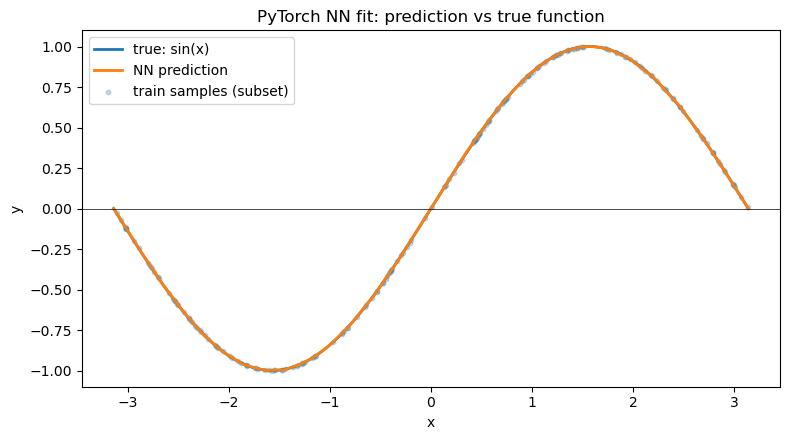

In [48]:
# ----------------------------
# 5) Evaluation + plot
# ----------------------------
# Test grid (in original x units)
x_grid = np.linspace(-np.pi, np.pi, 400).reshape(-1, 1).astype(np.float32)
y_true = np.sin(x_grid).astype(np.float32)
x_grid_n = (x_grid - x_mean) / x_std

xg = torch.from_numpy(x_grid_n).to(device)

model.eval()
with torch.no_grad():
    y_pred = model(xg).cpu().numpy()

mse = np.mean((y_pred - y_true) ** 2)
print("test MSE:", mse)

plt.figure(figsize=(8, 4.5))
plt.plot(x_grid, y_true, label="true: sin(x)", linewidth=2)
plt.plot(x_grid, y_pred, label="NN prediction", linewidth=2)
plt.scatter(x[:200], y[:200], s=10, alpha=0.25, label="train samples (subset)")
plt.axhline(0, color="black", linewidth=0.5)
plt.title("PyTorch NN fit: prediction vs true function")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

# ----------------------------
# 6) (Pedagogical) What PyTorch is doing for you
# ----------------------------
# - model.parameters() contains W1, b1, W2, b2
# - loss.backward() applies the chain rule to compute all gradients:
#     dL/dW1, dL/db1, dL/dW2, dL/db2
# - optimizer.step() performs the SGD update using these gradients
